In [1]:
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

# entropy & stats
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import pywt

# console 列印
from rich.console import Console
from rich.table import Table

console = Console()

# ==== 使用者參數 ====
selected_attack = "UDP"  # 攻擊類型關鍵字，如 "Syn", "UDP", "UDPLag"...
base_path = '/Users/hungwei/Desktop/Proj/AI_DDOS/data/2019'

# ==== 找 parquet 檔案 ====
train_fp = os.path.join(base_path, f"{selected_attack}-training.parquet")
test_fp  = os.path.join(base_path, f"{selected_attack}-testing.parquet")
file_paths = [p for p in (train_fp, test_fp) if os.path.isfile(p)]
if not file_paths:
    raise FileNotFoundError(f"No parquet files for attack '{selected_attack}' in {base_path}")

# ==== 讀資料 ====
dfs = [pd.read_parquet(fp) for fp in file_paths]
df = pd.concat(dfs, ignore_index=True)

# ==== 清理 & 篩選 ====
df.columns = df.columns.str.strip()
if 'Label' in df.columns:
    df = df[df['Label'].isin([selected_attack, "Benign"])].copy()
    df['Label'] = df['Label'].apply(lambda x: selected_attack if x != 'Benign' else x)

# ==== 顯示 Label 分布 ====
label_counts = df['Label'].value_counts()
total_count = len(df)

console.print("\n[bold cyan]標籤分布統計：[/]")
for label, count in label_counts.items():
    console.print(f"[yellow]{label:<8}[/]: {count} 筆 ({(count/total_count)*100:.2f}%)")
console.print(f"[bold]總資料筆數：{total_count}[/]")


# ==== 衍生特徵 ====
df['PSH Flags Ratio']          = df['Fwd PSH Flags'] / (df['Bwd PSH Flags'] + 1e-6)
df['Flow Packets/Bytes Ratio'] = df['Flow Packets/s'] / (df['Flow Bytes/s'] + 1e-6)
df['Total Packets']            = df['Total Fwd Packets'] + df['Total Backward Packets']
df['Active-Idle Mean Diff']    = df['Active Mean'] - df['Idle Mean']

selected_features = [
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/Bytes Ratio",
    "Total Packets",
    "Flow IAT Mean",
    "PSH Flags Ratio",
    "Active-Idle Mean Diff"
]

# 補 NA 並轉整數
df[selected_features] = df[selected_features].fillna(0).astype(int)

# ==== 計算函式 ====

def calc_shannon_entropy(data):
    if data.size == 0 or np.all(data == data[0]):
        return 0.0
    c = np.bincount(data); p = c / c.sum(); p = p[p>0]
    return -np.sum(p * np.log2(p))


def calc_renyi_entropy(data, α=2):
    c = np.bincount(data); p = c / c.sum(); p = p[p > 0]
    return 1/(1-α) * np.log2((p**α).sum())

def calc_tsallis_entropy(data, q=1.5):
    c = np.bincount(data); p = c / c.sum(); p = p[p > 0]
    return (1 - (p**q).sum()) / (q - 1)

def calc_min_entropy(data):
    c = np.bincount(data); p = c / c.sum()
    return -np.log2(p.max())

def calc_wavelet_entropy(data):
    coeffs = pywt.wavedec(data, 'db1', level=3)
    E = np.array([np.sum(c**2) for c in coeffs])
    p = E / E.sum(); p = p[p > 0]
    return -np.sum(p * np.log2(p))

def calc_fourier_energy(data):
    F = fft(data)
    return np.sum(np.abs(F)**2)

def extract_features(arr):
    return {
        "shannon":         calc_shannon_entropy(arr),
        "renyi_2":         calc_renyi_entropy(arr, 2),
        "tsallis_1.5":     calc_tsallis_entropy(arr, 1.5),
        "min_entropy":     calc_min_entropy(arr),
        "skewness":        skew(arr),
        "kurtosis":        kurtosis(arr),
        "wavelet_entropy": calc_wavelet_entropy(arr),
        "fourier_energy":  calc_fourier_energy(arr),
    }

# ==== 攻擊-特徵映射 ====

attack_feature_cfg = {
    "Syn":    ["shannon", "skewness"],
    "UDP":    ["shannon", "renyi_2", "wavelet_entropy"],
    "UDPLag": ["fourier_energy", "skewness"],
    "DNS":    ["min_entropy", "wavelet_entropy", "skewness"],
    "NTP":    ["skewness", "kurtosis"],
    "LDAP":   ["tsallis_1.5", "renyi_2"],
    "MSSQL":  ["tsallis_1.5", "skewness"],
    "NetBIOS":["shannon"],
    "Portmap":["renyi_2"],
    "TFTP":   ["fourier_energy", "wavelet_entropy"],
}

# ==== 執行並輸出 ====

console.print(f"[bold green]計算攻擊型態：{selected_attack}[/]")



# ==== 修改 extract_features，僅計算需要的方法 ====

# 先把所有可用的計算函式放到一個 dict 裡
metric_funcs = {
    "shannon":         calc_shannon_entropy,
    "renyi_2":         lambda arr: calc_renyi_entropy(arr, 2),
    "tsallis_1.5":     lambda arr: calc_tsallis_entropy(arr, 1.5),
    "min_entropy":     calc_min_entropy,
    "skewness":        skew,
    "kurtosis":        kurtosis,
    "wavelet_entropy": calc_wavelet_entropy,
    "fourier_energy":  calc_fourier_energy,
}

# 讓 extract_features 接受一個 methods 列表，並且只跑那些才會跑的
def extract_features(arr, methods):
    feats = {}
    for m in methods:
        func = metric_funcs.get(m)
        if func is None:
            continue
        # 如果是 scipy.stats 的函式，且資料幾乎一樣，先跳過避免警告
        if m in ("skewness", "kurtosis") and (arr.size == 0 or np.all(arr == arr[0])):
            feats[m] = 0.0
        else:
            feats[m] = func(arr)
    return feats

# ==== 執行並輸出 ====


methods = attack_feature_cfg.get(selected_attack, [])
sub = df[df['Label'] == selected_attack]
if sub.empty:
    console.print(f"[red]找不到 {selected_attack} 資料[/]")
else:
    # 收集結果
    results = {}
    for feat in selected_features:
        arr = sub[feat].to_numpy()
        feats = extract_features(arr, methods)
        results[feat] = feats  # 只會有 methods 裡的 key

    # 用 rich.table 印出
    table = Table(show_header=True, header_style="bold magenta")
    table.add_column("Feature")
    for m in methods:
        table.add_column(m)
    for feat, stats in results.items():
        row = [feat] + [f"{stats.get(m, 0.0):.4f}" for m in methods]
        table.add_row(*row)
    console.print(table)



標籤分布統計：

UDP     : 14792 筆 (75.21%)

Benign  : 4875 筆 (24.79%)

總資料筆數：19667

計算攻擊型態：UDP

/var/folders/sq/hg8np8js4x92j1nx8y_mlls80000gn/T/ipykernel_81739/2238754121.py:93: RuntimeWarning: invalid value encountered in divide
  p = E / E.sum(); p = p[p > 0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Feature                  ┃ shannon ┃ renyi_2 ┃ wavelet_entropy ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Protocol                 │ 0.0000  │ -0.0000 │ 0.0000          │
│ Flow Duration            │ 12.6013 │ 10.4409 │ 1.6166          │
│ Flow Bytes/s             │ 10.8538 │ 10.4219 │ 1.8189          │
│ Flow Packets/Bytes Ratio │ 0.0000  │ -0.0000 │ -0.0000         │
│ Total Packets            │ 1.5439  │ 1.2119  │ 1.4449          │
│ Flow IAT Mean            │ 11.5398 │ 10.0287 │ 0.5831          │
│ PSH Flags Ratio          │ 0.0000  │ -0.0000 │ -0.0000         │
│ Active-Idle Mean Diff    │ 0.0000  │ -0.0000 │ -0.0000         │
└──────────────────────────┴─────────┴─────────┴─────────────────┘

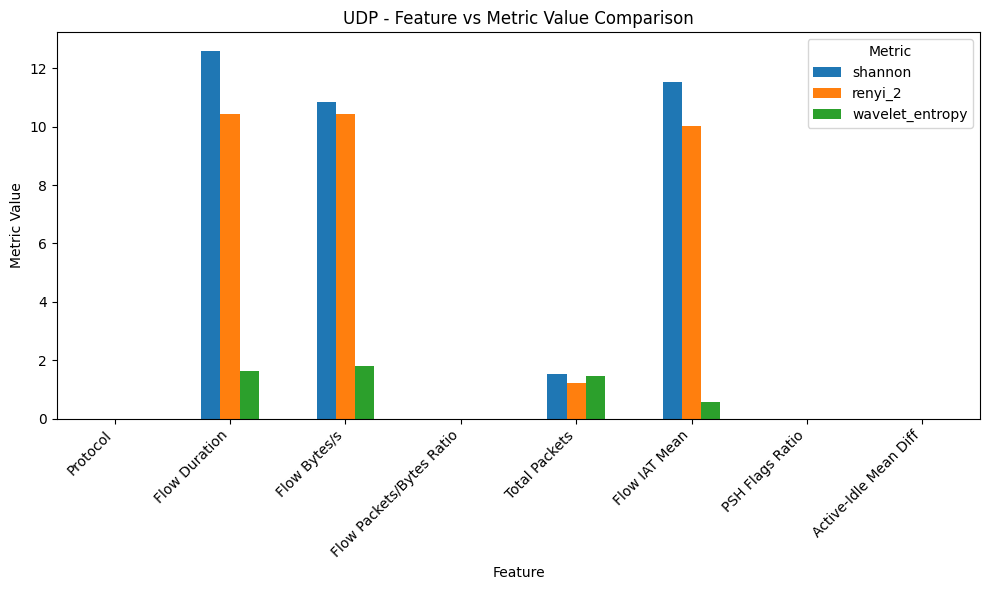

In [2]:
# ==== Plot Quantification Result Charts ====

# Convert results to DataFrame: index = feature, columns = methods
import pandas as pd
res_df = pd.DataFrame(results).T  # shape: [n_features × n_methods]

# 1) Grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
res_df.plot(kind='bar', ax=ax)  # Default matplotlib colors
ax.set_title(f"{selected_attack} - Feature vs Metric Value Comparison")
ax.set_xlabel("Feature")
ax.set_ylabel("Metric Value")
ax.legend(title="Metric", loc="best")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



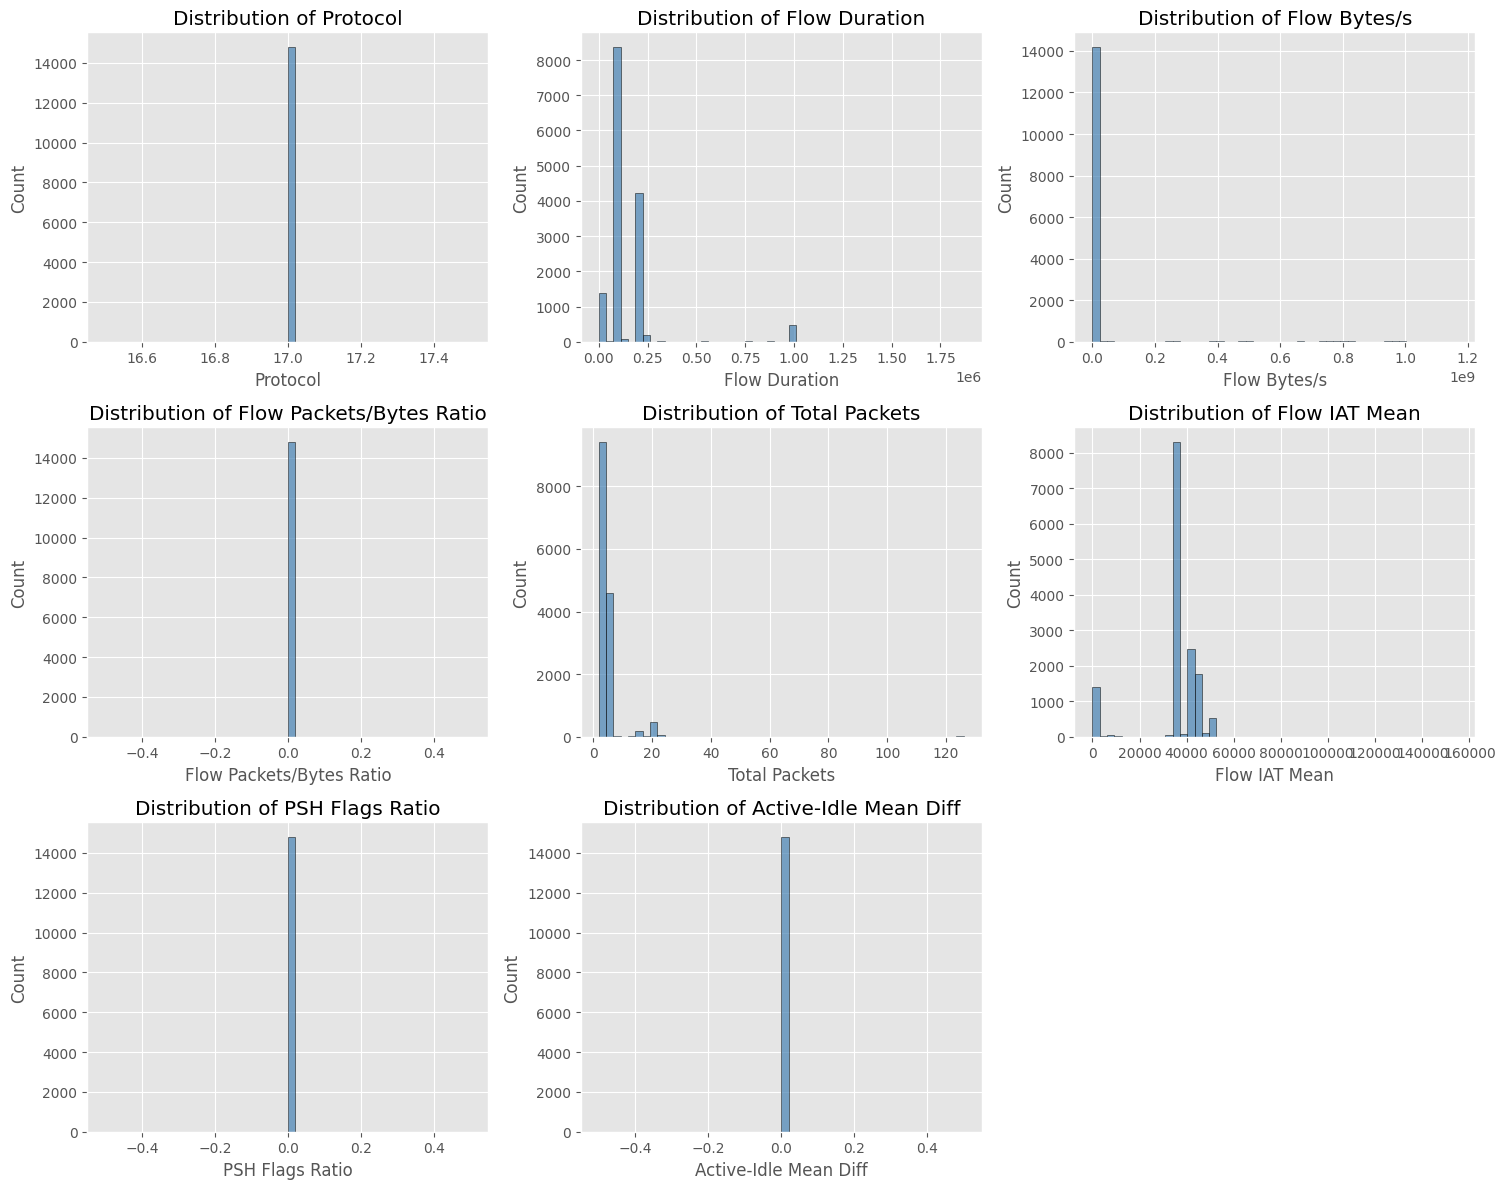

In [3]:
# ==== 顯示數值分佈圖 ====
import matplotlib.pyplot as plt

# 設定畫圖風格
plt.style.use("ggplot")
n_cols = 3
n_rows = int(np.ceil(len(selected_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for idx, feat in enumerate(selected_features):
    ax = axes[idx]
    data = sub[feat].values
    ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f"Distribution of {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")

# 移除多餘的空圖
for i in range(len(selected_features), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()
